In [421]:
#!/usr/bin/env python
# coding: utf-8

In [422]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os, sys
from os.path import basename

In [423]:
def set_labels(obj, xlabel, ylabel):
    obj.set_xlabel(xlabel, labelpad=50)
    obj.set_ylabel(ylabel, labelpad=50)
    obj.tick_params(axis='x',pad=50)
    obj.tick_params(axis='y',pad=50)

In [424]:
infile = "/home/marek/Downloads/fase23-experiments/dataraces/results.csv"
#infile = "/home/marek/vamos/vamos/fase23-experiments/dataraces/results.csv"
data = pd.read_csv(infile, header=0, skiprows=1,
                   names=["benchmark",
                          "tsan-races", "tsan-usertime", "tsan-systime", "tsan-time", "tsan-mem",
                          "hel-races", "hel-usertime", "hel-systime", "hel-time", "hel-mem",
                          "vamos-races", "vamos-usertime", "vamos-systime", "vamos-time", "vamos-mem",
                          "vamos-mem-mon", "vamos-eventsnum", "vamos-drop", "vamos-holes"],
                   )

first, replace time in timeouts with 0, then we will get the limits of other<br>
times and set a new time for timeout values

In [425]:
data.loc[data["tsan-races"].astype(str).str.contains("TO"), "tsan-time"] = 0.0
data.loc[data["hel-races"].astype(str).str.contains("TO"), "hel-time"] = 0.0
data.loc[data["vamos-races"].astype(str).str.contains("TO"), "vamos-time"] = 0.0

In [426]:
data["tsan-time"] = data["tsan-time"].astype(float)
data["hel-time"] = data["hel-time"].astype(float)
data["vamos-time"] = data["vamos-time"].astype(float)

In [427]:
lim = max(max(data["tsan-time"]),
          max(data["hel-time"]),
          max(data["vamos-time"]))

In [428]:
timeout = 1.3*lim
lim = timeout*1.05
assert lim > 0
#print(f"lim: {lim}, timeout: {timeout}")

In [429]:
data.loc[data["tsan-races"].astype(str).str.contains("TO"), "tsan-time"] = timeout
data.loc[data["hel-races"].astype(str).str.contains("TO"), "hel-time"] = timeout
data.loc[data["vamos-races"].astype(str).str.contains("TO"), "vamos-time"] = timeout

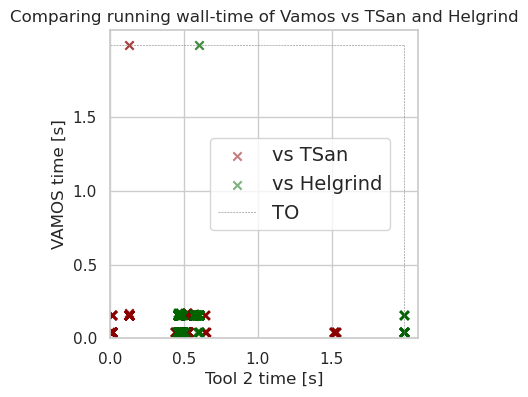

In [430]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(4,4))
fig.tight_layout()
s = plt.scatter(data["tsan-time"], data["vamos-time"], color="DarkRed", marker="x",  alpha=.5)
s = plt.scatter(data["hel-time"], data["vamos-time"], color="DarkGreen", marker="x", alpha=.5)
plt.plot([0, timeout], [timeout, timeout], color="gray", linestyle="dashed", linewidth=0.4)
plt.plot([timeout, timeout], [0, timeout], color="gray", linestyle="dashed", linewidth=0.4)
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xticks([x/10 for x in range(0, int(10*timeout), 5)])
plt.yticks([x/10 for x in range(0, int(10*timeout), 5)])
# plt.xscale("log")
# plt.yscale("log")
# plt.grid(ls='--')
leg = plt.legend(["vs TSan", "vs Helgrind", "TO"],
                 fontsize=14,
                 loc="center right",
                 bbox_to_anchor=(0.94, 0.5)
                )
if not os.environ.get("NOCAP"):
    plt.title("Comparing running wall-time of Vamos vs TSan and Helgrind")
plt.ylabel("VAMOS time [s]")
plt.xlabel("Tool 2 time [s]")
plt.gca().set_aspect('equal')
#plt.subplots_adjust(wspace=0.03, hspace=0)
plt.savefig("dataraces_times.pdf", bbox_inches='tight', dpi=300)

In [431]:
infofile = "/home/marek/vamos/vamos/fase23-experiments/dataraces/benchmarks/info.txt"
info = pd.read_csv(infofile, delimiter=" ", header=0, skiprows=0,
                   dtype={"benchmark" : str, "has-race" : bool, "is-nondet" :bool})
INFO = {}
for idx, row in info.iterrows():
    INFO[row["benchmark"].strip()] = row


In [469]:
def get_races(tool):
    tmp = data.loc[~(data[f"{tool}-races"].astype(str).str.contains("TO")), ("benchmark", f"{tool}-races")]
    tmp[f"{tool}-races"] = tmp[f"{tool}-races"].astype(int)
    tmp = tmp.groupby("benchmark").agg(['min', 'max'])
    tmp.reset_index(inplace=True)                  
    tmp["is-racy"] = tmp["benchmark"].apply(lambda b: INFO[b.strip()]["has-race"])
    tmp["is-nondet"] = tmp["benchmark"].apply(lambda b: INFO[b.strip()]["is-nondet"])
    tmp = tmp.loc[~tmp["is-nondet"]]
    #print("Records: ", len(tmp))
    return tmp

def get_timeouts(tool):
    tmp = pd.DataFrame()
    tmp["benchmark"] = data["benchmark"]
     # are all answers for a benchmark TO?
    tmp["is-to"] = data[f"{tool}-races"].apply(lambda x: True if "TO" in str(x) else False)
    tmp["is-nondet"] = tmp["benchmark"].apply(lambda b: INFO[b.strip()]["is-nondet"])
    tmp = tmp.loc[~tmp["is-nondet"]]
    tmp = tmp.groupby("benchmark").all()
    tmp = tmp.loc[tmp[f"is-to"]]  
    tmp.reset_index(inplace=True)
  
    return tmp

In [470]:
tmp = get_races("tsan")

tsan_race_corr = tmp.loc[(tmp[("is-racy")]) & (tmp[("tsan-races", "max")].astype(int) > 0)]
tsan_race_wrng = tmp.loc[(~tmp[("is-racy")]) & (tmp[("tsan-races", "max")].astype(int) > 0)]
tsan_norace_corr = tmp.loc[(~tmp[("is-racy")]) & (tmp[("tsan-races", "max")].astype(int) == 0)]
tsan_norace_wrng = tmp.loc[(tmp[("is-racy")]) & (tmp[("tsan-races", "max")].astype(int) == 0)]
tsan_to = get_timeouts("tsan")

Records:  118


In [471]:
tmp = get_races("hel")

hel_race_corr = tmp.loc[(tmp[("is-racy")]) & (tmp[("hel-races", "max")].astype(int) > 0)]
hel_race_wrng = tmp.loc[(~tmp[("is-racy")]) & (tmp[("hel-races", "max")].astype(int) > 0)]
hel_norace_corr = tmp.loc[(~tmp[("is-racy")]) & (tmp[("hel-races", "max")].astype(int) == 0)]
hel_norace_wrng = tmp.loc[(tmp[("is-racy")]) & (tmp[("hel-races", "max")].astype(int) == 0)]
hel_to = get_timeouts("hel")

tmp.join(hel_to).reset_index().to_html("/tmp/r.html")

Records:  115


/tmp/ipykernel_2168/2925926829.py:9: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  tmp.join(hel_to).reset_index().to_html("/tmp/r.html")


In [472]:
tmp = get_races("vamos")
vamos_race_corr = tmp.loc[(tmp[("is-racy")]) & (tmp[("vamos-races", "max")].astype(int) > 0)]
vamos_race_wrng = tmp.loc[(~tmp[("is-racy")]) & (tmp[("vamos-races", "max")].astype(int) > 0)]
vamos_norace_corr = tmp.loc[(~tmp[("is-racy")]) & (tmp[("vamos-races", "max")].astype(int) == 0)]
vamos_norace_wrng = tmp.loc[(tmp[("is-racy")]) & (tmp[("vamos-races", "max")].astype(int) == 0)]
vamos_to = get_timeouts("vamos")
tmp.set_index("benchmark").join(vamos_to.set_index("benchmark"), on="benchmark", how="inner")

Records:  118


/tmp/ipykernel_2168/1602314316.py:7: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  tmp.set_index("benchmark").join(vamos_to.set_index("benchmark"), on="benchmark", how="inner")


,"(vamos-races, min)","(vamos-races, max)","(is-racy, )","(is-nondet, )",is-to,is-nondet
benchmark,,,,,,


In [473]:
def get_times(tool):
    tmp = data.loc[~(data[f"{tool}-races"].astype(str).str.contains("TO")), ("benchmark", f"{tool}-time")]
    tmp = tmp.groupby("benchmark").agg("mean")
    return tmp[f"{tool}-time"].sort_values().reset_index()

def plot_times(ax, tool, color):
    times = get_times(tool)
    return ax.plot(times.index, times[f"{tool}-time"], color=color)

<Figure size 1200x300 with 0 Axes>

<Figure size 1200x300 with 0 Axes>

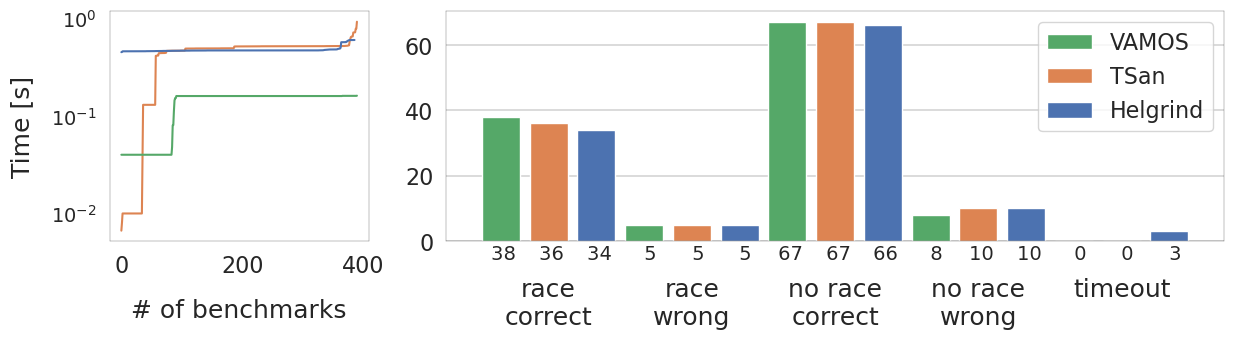

In [474]:
plt.clf()
figs_size=(12, 3)
font_scale = 1
sns.set(rc={'figure.figsize':figs_size},
        font_scale=font_scale)
plt.figure(figsize=figs_size)
sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.25,  0.75]})
fig.tight_layout()
plt.yticks(fontsize=16)
######## SCATTERS ######


colors = sns.color_palette("deep").as_hex()
vamos_color=colors[2]
tsan_color=colors[1]
hel_color=colors[0]


plot_times(ax1, "tsan", color=tsan_color)
plot_times(ax1, "hel", color=hel_color)
plot_times(ax1, "vamos", color=vamos_color)
ax1.set_yscale("log")
#s = ax1.scatter(data["tsan-time"], data["vamos-time"], color="DarkRed", marker="x",  alpha=.5)
#s = ax1.scatter(data["hel-time"], data["vamos-time"], color="DarkGreen", marker="x", alpha=.5)
#ax1.plot([0, timeout], [timeout, timeout], color="gray", linestyle="dashed", linewidth=0.4)
#ax1.plot([timeout, timeout], [0, timeout], color="gray", linestyle="dashed", linewidth=0.4)
#ax1.set_xlim(0, lim)
#ax1.set_ylim(0, lim)
#ax1.set_xticks([x/10 for x in range(0, int(10*timeout), 5)],
#               [f"{x/10:.1f}" for x in range(0, int(10*timeout), 5)],
#               fontsize=16)
#ax1.set_yticks([x/10 for x in range(0, int(10*timeout), 5)],
#               [f"{x/10:.1f}" for x in range(0, int(10*timeout), 5)],
#               fontsize=16)
#ax1.grid(ls='--')
#leg = ax1.legend(["TSan", "Helgrind", "VAMOS"],
#                 fontsize=16,
                # loc="center right",
                 #bbox_to_anchor=(0.94, 0.5)
#                )
#if not os.environ.get("NOCAP"):
#    ax1.title("Comparing running wall-time of Vamos vs TSan and Helgrind")
ax1.set_ylabel("Time [s]", fontsize=18, labelpad=12)
ax1.set_xlabel("# of benchmarks", fontsize=18, labelpad=15)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=14)



######## BARS ##########

vamos = [vamos_race_corr, vamos_race_wrng, vamos_norace_corr, vamos_norace_wrng, vamos_to]
tsan  = [tsan_race_corr,  tsan_race_wrng,  tsan_norace_corr,  tsan_norace_wrng,  tsan_to]
hel   = [hel_race_corr,   hel_race_wrng,   hel_norace_corr,   hel_norace_wrng,   hel_to]

labels =[
    "race\ncorrect", "race\nwrong", "no race\ncorrect", "no race\nwrong", "timeout"
]


barwidth=1
tools_num = 3
bars_no = len(labels)

sns.set_style("whitegrid")

bar1 = ax2.bar([x*barwidth for x in range(0, tools_num*bars_no, tools_num)],
               [len(g) for g in vamos],
               color=vamos_color, label="VAMOS")
bar2 = ax2.bar([x*barwidth for x in range(1, tools_num*bars_no, tools_num)],
               [len(g) for g in tsan],
               color=tsan_color, label="TSan")
bar3 = ax2.bar([x*barwidth for x in range(2, tools_num*bars_no, tools_num)],
               [len(g) for g in hel],
               color=hel_color, label="Helgrind")

ax2.set_xticks([x*barwidth for x in range(1, tools_num*bars_no, tools_num)], labels, fontsize=18)

ax2.tick_params(axis='x', pad=20)
ypos = -4
for x in range(0, bars_no):
    ax2.text(x*tools_num*barwidth, ypos,
             f"{len(vamos[x]):3}",
             fontsize=14,
             horizontalalignment='center',
             verticalalignment='center')
    ax2.text(x*tools_num*barwidth + 1, ypos,
             f"{len(tsan[x]):3}",
             fontsize=14,
             horizontalalignment='center',
             verticalalignment='center')
    ax2.text(x*tools_num*barwidth + 2, ypos,
             f"{len(hel[x]):3}",
             fontsize=14,
             horizontalalignment='center',
             verticalalignment='center')
ax2.legend(fontsize=16)
ax2.grid(True, axis='y', color = "black", linewidth = "0.2", linestyle = "-")

plt.setp(ax1.spines.values(), linewidth=0.2)
plt.setp(ax2.spines.values(), linewidth=0.2)

#if not os.environ.get("NOCAP"):
#    plt.title("The correctness of verdicts")
plt.subplots_adjust(wspace=0.15, hspace=0)
plt.savefig("dataraces.pdf", bbox_inches='tight', dpi=600)

In [475]:
v = sum(map(len, vamos))
t = sum(map(len, tsan))
h = sum(map(len, hel))
assert t == h, (t, h)
assert v == t, (v, t)


<Figure size 1200x300 with 0 Axes>

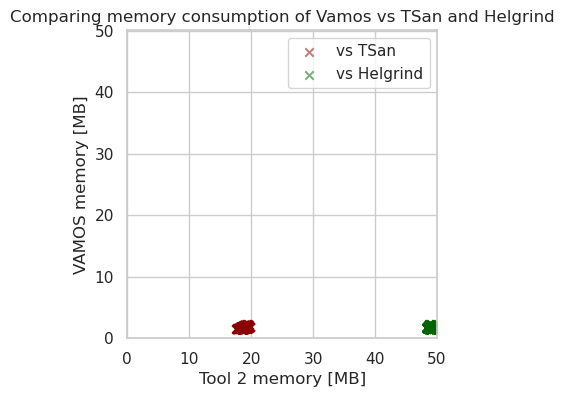

In [345]:
data2 = data[~(data["tsan-races"].astype(str).str.contains("TO") |
               data["hel-races"].astype(str).str.contains("TO") |
               data["vamos-races"].astype(str).str.contains("TO"))]
mem = pd.DataFrame()
mem["tsan-mem"] = data2["tsan-mem"].astype(float)/1024.0
mem["hel-mem"] = data2["hel-mem"].astype(float)/1024.0
mem["vamos-mem"] = data2["vamos-mem"].astype(float)/1024.0
plt.clf()
fig = plt.figure(figsize=(4,4))
fig.tight_layout()
s = plt.scatter(mem["tsan-mem"], mem["vamos-mem"], color="DarkRed", marker="x",  alpha=.5)
s = plt.scatter(mem["hel-mem"], mem["vamos-mem"], color="DarkGreen", marker="x", alpha=.5)
lim = max(max(mem["tsan-mem"]), max(mem["hel-mem"]), max(mem["vamos-mem"]))
plt.xlim(0, lim)
plt.ylim(0,lim)
plt.legend(["vs TSan", "vs Helgrind"])
# gca = plt.gca()
# gca.set_aspect('equal')
plt.ylabel("VAMOS memory [MB]")
plt.xlabel("Tool 2 memory [MB]")
if not os.environ.get("NOCAP"):
    plt.title("Comparing memory consumption of Vamos vs TSan and Helgrind")
plt.savefig("dataraces_memory.pdf", bbox_inches='tight', dpi=300)

In [495]:
# how many answers diverged from TSan/Helgrind?

# get rows where all tools answered
fil = data.loc[~(data["tsan-races"].astype(str).str.contains("TO") |
               data["hel-races"].astype(str).str.contains("TO") |
               data["vamos-races"].astype(str).str.contains("TO"))]
tmp = pd.DataFrame()
tmp["benchmark"] = fil["benchmark"]
for tool in ("tsan", "hel", "vamos"):
    tmp[f"{tool}-found"] = fil[f"{tool}-races"].apply(lambda x: False if "TO" in str(x) else int(x) > 0)

# have the tool found a race in _all_ trials?
tmp = tmp.groupby("benchmark").all()
all_agree = tmp.loc[(tmp["tsan-found"] == tmp["hel-found"]) &
                    (tmp["tsan-found"] == tmp["vamos-found"])]
print(f"When all tools finished, they agreed on {len(all_agree)} from {len(tmp)} benchmarks, i.e. {100*(float(len(all_agree))/len(tmp)) :.2f}% of cases")

When all tools finished, they agreed on 385 from 387 benchmarks, i.e. 99.48% of cases


In [494]:
# how many answers diverged from TSan/Helgrind?

# get rows where all tools answered
fil = data.loc[~(data["tsan-races"].astype(str).str.contains("TO") |
               data["hel-races"].astype(str).str.contains("TO"))]
tmp = pd.DataFrame()
tmp["benchmark"] = fil["benchmark"]
for tool in ("tsan", "hel"):
    tmp[f"{tool}-found"] = fil[f"{tool}-races"].apply(lambda x: False if "TO" in str(x) else int(x) > 0)

# have the tool found a race in _all_ trials?
tmp = tmp.groupby("benchmark").all()
agree = tmp.loc[(tmp["tsan-found"] == tmp["hel-found"])]
print(f"When TSan and Helgrind finished, they agreed on {len(agree)} from {len(tmp)} benchmarks, i.e.  {100*(float(len(all_agree))/len(tmp)) :.2f}% of cases")

When TSan and Helgrind finished, they agreed on 386 from 387 benchmarks, i.e.  99.48% of cases


In [492]:
# how many answers diverged from TSan/Helgrind?

# get rows where all tools answered
fil = data.loc[~(data["tsan-races"].astype(str).str.contains("TO") |
               data["vamos-races"].astype(str).str.contains("TO"))]
tmp = pd.DataFrame()
tmp["benchmark"] = fil["benchmark"]
for tool in ("tsan", "vamos"):
    tmp[f"{tool}-found"] = fil[f"{tool}-races"].apply(lambda x: False if "TO" in str(x) else int(x) > 0)

# have the tool found a race in _all_ trials?
tmp = tmp.groupby("benchmark").all()
agree = tmp.loc[(tmp["tsan-found"] == tmp["vamos-found"])]
print(f"When TSan and VAMOS finished, they agreed on {len(agree)} from {len(tmp)} benchmarks, i.e. {100*(float(len(all_agree))/len(tmp)) :.2f}% of cases")

When TSan and VAMOS finished, they agreed on 390 from 391 benchmarks, i.e. 98.47% of cases


In [493]:
# how many answers diverged from TSan/Helgrind?

# get rows where all tools answered
fil = data.loc[~(data["hel-races"].astype(str).str.contains("TO") |
               data["vamos-races"].astype(str).str.contains("TO"))]
tmp = pd.DataFrame()
tmp["benchmark"] = fil["benchmark"]
for tool in ("hel", "vamos"):
    tmp[f"{tool}-found"] = fil[f"{tool}-races"].apply(lambda x: False if "TO" in str(x) else int(x) > 0)

# have the tool found a race in _all_ trials?
tmp = tmp.groupby("benchmark").all()
agree = tmp.loc[(tmp["hel-found"] == tmp["vamos-found"])]
print(f"When Helgrind and VAMOS finished, they agreed on {len(agree)} from {len(tmp)} benchmarks, i.e. {100*(float(len(all_agree))/len(tmp)) :.2f}% of cases")

When Helgrind and VAMOS finished, they agreed on 385 from 387 benchmarks, i.e. 99.48% of cases
